In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
from   ehtim.calibrating import self_cal as sc
import time
plt.close('all')
ttype = 'direct'

/Users/jiahuitang/opt/anaconda3/lib/python3.8/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


Welcome to eht-imaging! v 1.2.3 



### Site info

* `SITE`: name of the telescope.
* `X`, `Y` and `Z`: coordinates of telescope
* `SEFD`: system equivalent flux density. Lower values indicate more sensitive performance. Don't know what *L* and *R* really means.

### Measurements

* `tint`: scan integration time in seconds.
* `T1` and `T2`: sites on 2 ends of a baseline.
* `Tau1` and `Tau2`: base optical depth, opacity for each site.
* `U` and `V`: spatial frequency. U for east-west and V for north-south. In terms of observed wavelengths.

## About the problem

**TL;DR**: reconstruct an image from its sparsely-sampled Fourier transform.


RML Objective Function:
$J(I) = \sum \alpha_D \chi_D^2(I, d) - \sum \beta_RS_R(I)$


# GroundTruth Data

Loading text image:  ./models/avery_sgra_eofn.txt


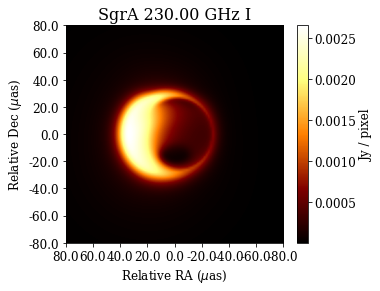

In [2]:
im = eh.image.load_txt("./models/avery_sgra_eofn.txt")
eht = eh.array.load_txt("./arrays/EHT2017.txt")
im.display()
plt.show()

# Helper

In [3]:
# helper function
"""Compare to another image by computing normalized cross correlation,
normalized root mean squared error, or square root of the sum of squared differences."""

def compare(groundtruth, reconstructed_img):
    errormetric, im1_pad, im2_shift = groundtruth.compare_images(reconstructed_img, metric=['nxcorr', 'nrmse', 'rssd'], psize=None, target_fov=None, blur_frac=0.0, beamparams=[1.0, 1.0, 1.0])
    return errormetric

# Setup, EDA


In [4]:
tint_sec = 5 # integration time in seconds
tadv_sec = 600 # advance time between scans
tstart_hr = 0 # GMST time of the start of the observation
tstop_hr = 24 # GMST time of the end
bw_hz = 4e9 # bandwidth in Hz

# sgrscat=True blurs the visibilities with the Sgr A* scattering kernel for the appropriate image frequency
# ampcal and phasecal determine if gain variations and phase errors are included
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, sgrscat=True, ampcal=True, phasecal=False)

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!
Adding gain + phase errors to data and applying a priori calibration . . . 
   Applying atmospheric phase corruption: phasecal-->False
Adding thermal noise to data . . . 


/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:4034: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  x.plot(data[field1], data[field2], marker, markersize=markersize, color=color,


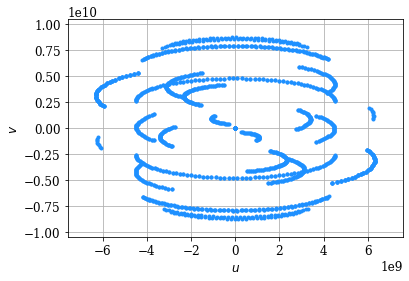

/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


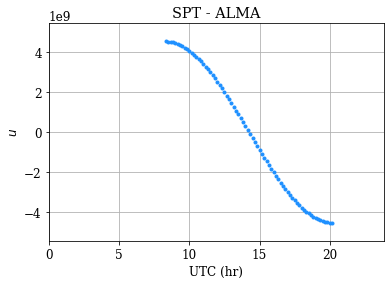

<AxesSubplot:title={'center':'SPT - ALMA'}, xlabel='UTC (hr)', ylabel='$u$'>

In [5]:
obs.plotall('u', 'v', conj=True)
obs.plot_bl('SPT', 'ALMA', 'u')

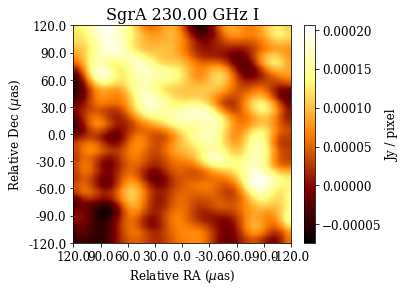

Clean beam parameters:  [1.19700015e-10 7.88398351e-11 1.38025520e+00]
Nominal Resolution:  1.1454586301106233e-10


In [6]:
npix = 32
fov = 1.5 * im.xdim * im.psize
dim = obs.dirtyimage(npix, fov)
dim.display()

# CLEAN Algorithm
beamparams = obs.fit_beam()
res = obs.res()
print("Clean beam parameters: " , beamparams)
print("Nominal Resolution: " ,res)

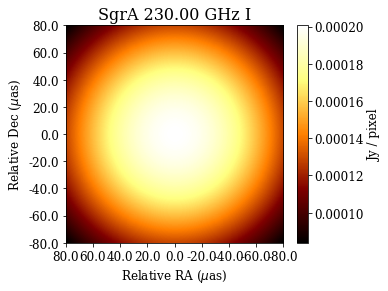

In [7]:
npix = 128
fov = 1 * im.fovx()
zbl = im.total_flux() # total flux Jensky(Jy)
prior_fwhm = 200 * eh.RADPERUAS # fwhw
emptyprior = eh.image.make_square(obs, npix, fov) # empty prior
flatprior = emptyprior.add_flat(zbl) # add flat background
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0)) # draw gauss core
gaussprior.display()
plt.show()

# Experiment with Different Parameters

In [8]:
import pandas as pd

In [9]:
d = ['vis', 'bs', 'amp', 'cphase', 'cphase_diag', 'camp', 'logcamp', 'logcamp_diag']
s = ['simple', 'gs', 'tv', 'tv2', 'l1w', 'lA','patch','compact','compact2','rgauss']

In [10]:
metrics_result = {}
flux = zbl

for dd in d:
    for ss in s:
        try:
            out = eh.imager_func(obs, gaussprior, gaussprior, flux, d1=dd, s1=ss,
                                 alpha_s1=1, alpha_d1=100, alpha_flux=100, alpha_cm=50,
                                 maxit=100, ttype=ttype, show_updates=False)
            metrics_result[(dd,ss)] = compare(im, out)
        except:
            continue

Generating I image...
Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 99338.357035 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 9933735.703522
Total Data 1:  1030
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 3.697192 s
J: 4633060.668485
Final Chi^2_1: 46325.414388 Chi^2_2: 1.000000  Chi^2_3: 1.000000
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Generating I image...
Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 99338.357035 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 9933735.703522
Total Data 1:  1030
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 3.502322 s
J: 4633063.156918
Final Chi^2_1: 46325.414388 Chi^2_2: 1.000000  Chi^2_3: 1.000000
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Generating I image...
Initial S_1: 0.053030 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 99338.357035 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 9933735.756552
Total Data 1:  1030
Total 

/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 213.149133 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 21214.913252
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 12.084942 s
J: 2.113189
Final Chi^2_1: 1.003342 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 213.149133 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 21214.913252
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 11.711199 s
J: 1.841317
Final Chi^2_1: 1.001018 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 0.053030 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 213.149133 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 21214.966282
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 10.222413 s
J: n

/Users/jiahuitang/Desktop/eht-imaging/ehtim/imaging/imager_utils.py:3176: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Amatrices = (np.array(A3_diag), np.array(tform_mats))
/Users/jiahuitang/Desktop/eht-imaging/ehtim/imaging/imager_utils.py:3178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(clphase_diag), np.array(sigma_diag), Amatrices)


Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 653.044348 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 66143.951062
Total Data 1:  98
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 10.224020 s
J: 5770.605396
Final Chi^2_1: 58.705723 Chi^2_2: 1.000000  Chi^2_3: 1.000000
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Generating I image...
Diagonalizing closure phases:: type vis, count min, scan 98/98 

Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 653.044348 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 66143.951062
Total Data 1:  98
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 13.527155 s
J: 5770.583853
Final Chi^2_1: 58.705618 Chi^2_2: 1.000000  Chi^2_3: 1.000000
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Generating I image...
Diagonalizing closure phases:: type vis, count min, scan 98/98 

Initial S_1: 0.053030 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 653.044348 Chi^2_2: 1.000000 Chi

/Users/jiahuitang/Desktop/eht-imaging/ehtim/imaging/imager_utils.py:3336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Amatrices = (np.array(A4_diag), np.array(tform_mats))
/Users/jiahuitang/Desktop/eht-imaging/ehtim/imaging/imager_utils.py:3338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(clamp_diag), np.array(sigma_diag), Amatrices)


Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 3120.473705 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 311947.370493
Total Data 1:  74
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 11.535634 s
J: -14.389437
Final Chi^2_1: 0.832601 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Diagonalizing log closure amplitudes:: type vis, count min, scan 74/74 

Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 3120.473705 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 311947.370493
Total Data 1:  74
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 11.365470 s
J: 44.568383
Final Chi^2_1: 1.384644 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Diagonalizing log closure amplitudes:: type vis, count min, scan 74/74 

Initial S_1: 0.053030 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 3120.473705 Chi^2_2: 1.00

In [11]:
df = pd.DataFrame.from_dict(metrics_result, orient='index')
df.columns = ['nxcorr', 'nrmse', 'rssd']
df

,nxcorr,nrmse,rssd
"(vis, simple)",0.495814,1.000000,2.740850e-13
"(vis, gs)",0.495814,1.000000,2.740850e-13
"(vis, tv)",0.491163,0.855926,2.345965e-13
"(vis, tv2)",0.495811,1.000000,2.740850e-13
"(vis, l1w)",0.495759,1.000000,2.740850e-13
...,...,...,...
"(logcamp_diag, lA)",0.496151,0.850138,2.330100e-13
"(logcamp_diag, patch)",0.468513,0.885265,2.426379e-13
"(logcamp_diag, compact)",0.498781,0.849369,2.327992e-13
"(logcamp_diag, compact2)",0.498781,0.849369,2.327992e-13


# BSMEM (Best Perfoming Algorithm)

In [12]:
flux = zbl
tt = time.time()
out = eh.imager_func(obs, gaussprior, gaussprior, flux, d1='bs', s1='simple',
                     alpha_s1=1, alpha_d1=100, alpha_flux=100, alpha_cm=50,
                     maxit=100, ttype=ttype, show_updates=False)

Generating I image...


/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 213.149133 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 21214.913252
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 12.774793 s
J: 2.113189
Final Chi^2_1: 1.003342 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


In [13]:
# Blur the image with a circular beam and image again to help convergance
out = out.blur_circ(res)
out = eh.imager_func(obs, out, out, flux,
                     d1='bs', s1='tv',
                     alpha_s1=1, alpha_d1=50,
                     alpha_flux=100, alpha_cm=50,
                     maxit=100,ttype=ttype, show_updates=False)

out = out.blur_circ(res/2.0)
out = eh.imager_func(obs, out, out, flux,
                     d1='bs', s1='tv',
                     alpha_s1=1, alpha_d1=10,
                     alpha_flux=100, alpha_cm=50,
                     maxit=100,ttype=ttype, show_updates=False)

print ("total time: ", time.time() - tt)

Generating I image...
Initial S_1: 0.137730 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 143.312537 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 7116.257516
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 11.427064 s
J: -2.890239
Final Chi^2_1: 0.937714 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 0.169752 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 32.794681 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 318.130561
Total Data 1:  645
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 11.033505 s
J: -0.690847
Final Chi^2_1: 0.910632 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
total time:  37.659921169281006


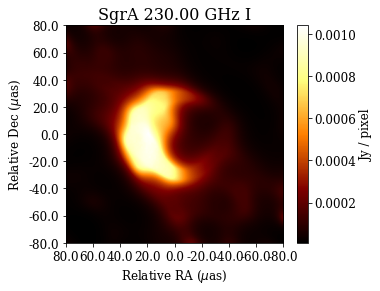

In [14]:
out.display()
plt.show()

In [15]:
print("metrics for BSMEM algorithm is ", compare(im,out))

metrics for BSMEM algorithm is  [0.950695494533002, 0.36700294889239543, 1.0058999879312454e-13]


No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 106/107 : [----------------------------- ]99%
self_cal time: 15.219179 s
Generating I image...
Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 517.364824 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 51636.482827
Total Data 1:  1030
Total Pixel #:  16384
Clipped Pixel #:  16384

time: 1.116502 s
J: -8.546826
Final Chi^2_1: 0.913660 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:4031: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  x.errorbar(data[field1], data[field2], xerr=sigx, yerr=sigy, label=labelstr,
/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:4034: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  x.plot(data[field1], data[field2], marker, markersize=markersize, color=color,


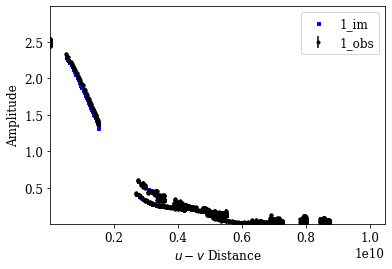

In [16]:
# Self - calibrate and image with vis amplitudes
obs_sc = sc.self_cal(obs, out)

out_sc = out.blur_circ(res)
out_sc = eh.imager_func(obs_sc, out_sc, out_sc, flux,
                        d1='vis', s1='simple',
                        alpha_s1=1, alpha_d1=100,
                        alpha_flux=100, alpha_cm=50,
                        maxit=50,ttype='fast',show_updates=False)


# Compare the visibility amplitudes to the data
out = out_sc
eh.comp_plots.plotall_obs_im_compare(obs, out,'uvdist','amp', clist=['b','m'],conj=True, ttype='fast')

# Blur the final image with 1/2 the clean beam
outblur = out.blur_gauss(beamparams, 0.5)

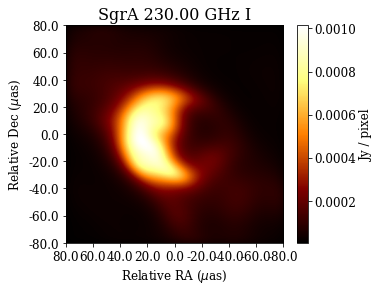

In [17]:
outblur.display()
plt.show()

# Ring Structure


Loading text image:  models/avery_sgra_eofn.txt


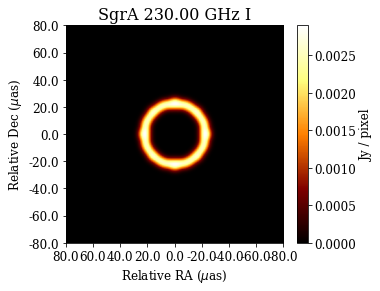

In [18]:
# Load the image and the array
im = eh.image.load_txt('models/avery_sgra_eofn.txt')
eht = eh.array.load_txt('arrays/EHT2017.txt')

im.imvec *= 0.0
im = im.add_crescent(1.0, 25.*eh.RADPERUAS,20.*eh.RADPERUAS, 0, 0)
im = im.blur_circ(5.0*eh.RADPERUAS)

# Look at the image
im.display()
plt.show()

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Generating I image...
Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 2780.415507 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 277944.349709
Total Data 1:  1030
Total Pixel #:  4096
Clipped Pixel #:  4096

time: 0.323609 s
J: 339.195121
Final Chi^2_1: 4.008687 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 1.060445 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 1361.386652 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 136051.814640
Total Data 1:  1030
Total Pixel #:  4096
Clipped Pixel #:  4096

time: 1.518072 s
J: 56.059911
Final Chi^2_1: 1.247828 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initia

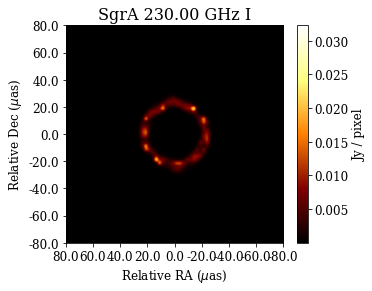

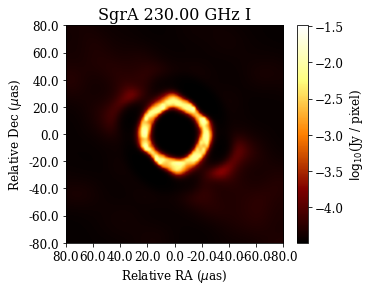

In [19]:
tint_sec = 5
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 4e9
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True)

res = obs.res() # nominal array resolution, 1/longest baseline

# Generate an image prior
npix = 64
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# Define the data products
d1 = 'vis'
d2 = False
alpha_d1 = 100.0
alpha_d2 = 0.0

# Image using MEM
flux = zbl
out  = eh.imager_func(obs, gaussprior, gaussprior, flux,
                      d1=d1, d2=d2, alpha_d1=alpha_d1, alpha_d2=alpha_d2, s1='simple', alpha_s1=10, ttype='nfft',
                      maxit=100, show_updates=False, beam_size=res, norm_reg=True)

for repeat in range(5):
    out  = eh.imager_func(obs, out.blur_circ(res), gaussprior, flux,
                          d1=d1, d2=d2, alpha_d1=alpha_d1, alpha_d2=alpha_d2, s1='simple', alpha_s1=10, ttype='nfft',
                          maxit=300, show_updates=False, beam_size=res, norm_reg=True)

out.display()
out.display(scale='log')
plt.show()

In [20]:
print("metrics for MEM algorithm is ", compare(im,out))

metrics for MEM algorithm is  [0.8624355775787029, 0.6240013431645595, 2.1395234576969597e-13]


Generating I image...
Initial S_1: 1.827033 S_2: 1.957031 S_3: 0.000000
Initial Chi^2_1: 226.405015 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 22580.202918
Total Data 1:  1030
Total Pixel #:  4096
Clipped Pixel #:  4096

time: 1.427625 s
J: 224.259046
Final Chi^2_1: 1.109241 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 1.672731 S_2: 3.128535 S_3: 0.000000
Initial Chi^2_1: 227.737490 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 22724.211635
Total Data 1:  1030
Total Pixel #:  4096
Clipped Pixel #:  4096

time: 1.413776 s
J: 215.581684
Final Chi^2_1: 1.130902 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 1.659154 S_2: 4.384781 S_3: 0.000000
Initial Chi^2_1: 228.558384 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 22818.677021
Total Data 1:  1030
Total Pixel #:  4096
Clipped Pixel #:  4096

ti

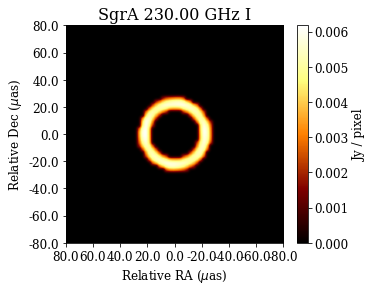

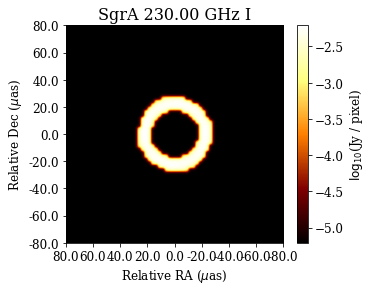

In [21]:
# Now with the tunable sparsity regularizer and tv2
alpha_A = 100.0
out2 = out.copy()

for repeat in range(5):
    alpha_A *= 2.0
    out2 = eh.imager_func(obs, out2.blur_circ(res/2.0), gaussprior, flux, d1=d1, d2=d2, alpha_d1=alpha_d1, alpha_d2=alpha_d2, s1='tv2', s2='lA', alpha_s1=10.0, alpha_s2=10.0, ttype='nfft', alpha_A = alpha_A, maxit=300, show_updates=False, beam_size=res, norm_reg=True)

for repeat in range(5):
    alpha_A *= 2.0
    out2 = eh.imager_func(obs, out2.blur_circ(res/2.0), gaussprior, flux, d1=d1, d2=d2, alpha_d1=alpha_d1, alpha_d2=alpha_d2, s1='tv2', s2='lA', alpha_s1=20.0, alpha_s2=20.0, ttype='nfft', alpha_A = alpha_A, maxit=500, show_updates=False, beam_size=res, norm_reg=True)

out2.display()
out2.display(scale='log')
plt.show()

In [22]:
print("metrics for regularized IA ring is ", compare(im,out2))

metrics for regularized IA ring is  [0.9847352225875895, 0.17408483174181927, 5.96887467023652e-14]


# Polarization

In [23]:
# Load the image and the array
im = eh.image.load_txt('./models/avery_sgra_eofn.txt')
eht = eh.array.load_txt('./arrays/EHT2017.txt')

# Observe the image
tint_sec = 5
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 400e9
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True,add_th_noise=False)
# Resolution
beamparams = obs.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res = obs.res() # nominal array resolution, 1/longest baseline
print("Clean beam parameters: " , beamparams)
print("Nominal Resolution: " ,res)

# Generate an image prior
npix = 64
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Loading text image:  ./models/avery_sgra_eofn.txt
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Clean beam parameters:  [1.19700015e-10 7.88398351e-11 1.38025520e+00]
Nominal Resolution:  1.1454586301106233e-10


In [24]:
# Generate an image prior
npix = 64
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# Image total flux with bispectrum
flux = zbl
imgr  = eh.imager.Imager(obs, gaussprior, gaussprior, flux,
                         data_term={'bs':100}, show_updates=False,
                         reg_term={'simple':1,'flux':100,'cm':50},
                         maxit=200, ttype='nfft')
imgr.make_image_I(grads=True, show_updates = False )

Initializing imager data products . . .
Imager run 1 


/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


time: 0.978349 s
J: 445.229511
chi2_bs : 5.43 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


In [25]:
# Blur the image with a circular beam and image again to help convergance
out = imgr.out_last()
imgr.init_next = out.blur_circ(res)
imgr.prior_next = imgr.init_next
imgr.dat_term_next = {'amp':50, 'cphase':100}
imgr.reg_term_next = {'tv2':100, 'flux':1,'cm':1}
imgr.make_image_I(show_updates = False )

out=imgr.out_last().threshold(0.01)

# Image polarization with the polarimetric ratio
imgr.init_next = out.blur_circ(0.25*res)
imgr.prior_next = imgr.init_next
imgr.transform_next = 'mcv'
imgr.dat_term_next = {'pvis':1}
imgr.reg_term_next = {'hw':1}
imgr.make_image_P(show_updates = False )

# blur and image again with the polarimetric ratio
out=imgr.out_last()
imgr.init_next = out.blur_circ(0,.5*res)
imgr.prior_next = imgr.init_next
imgr.transform_next = 'mcv'
imgr.dat_term_next = {'pvis':5}
imgr.reg_term_next = {'hw':1,'ptv':1.e2}
imgr.make_image_P(show_updates = False )

out = imgr.out_last()

Imager run 2 
changed number of data terms!
Recomputing imager data products . . .
time: 1.236397 s
J: 659.279365
chi2_amp : 13.99 chi2_cphase : 1.10 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging P: switching to Stokes!
changed polarization!
No polarimetric image in init_next!
--initializing with 10% pol and random orientation!
Recomputing imager data products . . .
time: 1.002115 s
J: -1.875758
chi2_pvis : 0.84 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Blurring polarization
Blurring polarization
Imager run 4 
Imaging P: switching to Stokes!
changed number of regularizer terms!
Recomputing imager data products . . .
time: 1.428665 s
J: 0.450869
chi2_pvis : 0.17 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


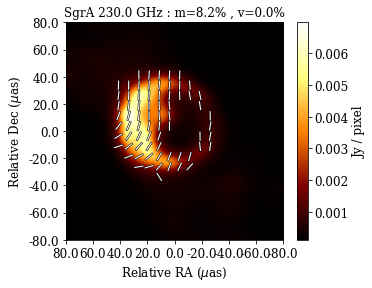

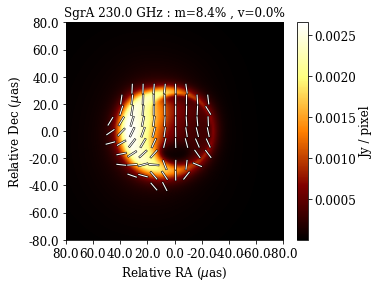

In [26]:
out.display(plotp=True)
im.display(plotp=True)
plt.show()

In [27]:
print("metrics for polarized algorithm is ", compare(im,out))

metrics for polarized algorithm is  [0.985118927527268, 0.1857405802006601, 8.339911402676505e-14]


# Rotate

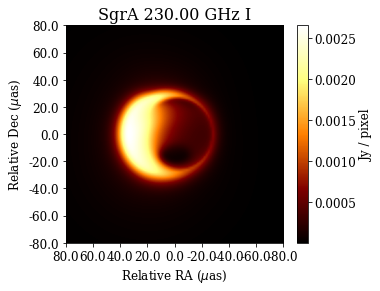

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Clean beam parameters:  [1.19700015e-10 7.88398351e-11 5.94857037e-01]
Nominal Resolution:  1.1454586301106233e-10


In [28]:
# Look at the image
im.display()

# Observe the image
# tint_sec is the integration time in seconds, and tadv_sec is the advance time between scans
# tstart_hr is the GMST time of the start of the observation and tstop_hr is the GMST time of the end
# bw_hz is the  bandwidth in Hz
# sgrscat=True blurs the visibilities with the Sgr A* scattering kernel for the appropriate image frequency
# ampcal and phasecal determine if gain variations and phase errors are included
tint_sec = 5
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 4e9
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True)

#############################
#rotate u,v coordinates
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))

coordsrot = np.array([np.dot(R,[obs.data['u'][i], obs.data['v'][i]]) for i in range(len(obs.data))])
obs.data['u'] = coordsrot[:,0]
obs.data['v'] = coordsrot[:,1]

#############################

# You can check out the dirty image, dirty beam, and clean beam
npix = 64
fov = 1.5*im.xdim * im.psize # slightly enlarge the field of view
dim = obs.dirtyimage(npix, fov)
dbeam = obs.dirtybeam(npix, fov)
cbeam = obs.cleanbeam(npix,fov)
# dim.display()
# dbeam.display()
# cbeam.display()

# Resolution
beamparams = obs.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res = obs.res() # nominal array resolution, 1/longest baseline
print("Clean beam parameters: " , beamparams)
print("Nominal Resolution: " ,res)

# Export the visibility data to uvfits/text
#obs.save_txt('obs.txt') # exports a text file with the visibilities
#obs.save_uvfits('obs.uvp') # exports a UVFITS file modeled on template.UVP

# Generate an image prior
npix = 32
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Generating I image...
Initial S_1: 0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 4933.132919 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 493213.291875
Total Data 1:  1030
Total Pixel #:  1024
Clipped Pixel #:  1024

time: 0.224088 s
J: 75.335563
Final Chi^2_1: 1.731547 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 0.651337 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 990.689974 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 49485.150040
Total Data 1:  1030
Total Pixel #:  1024
Clipped Pixel #:  1024

time: 0.198557 s
J: 14.200193
Final Chi^2_1: 1.257702 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Generating I image...
Initial S_1: 0.896806 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 126.890820 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 1259.805007
Total Data 1:  1030
Total Pixel #:  1024
Clipped Pixel #:  1024

tim

/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:4031: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  x.errorbar(data[field1], data[field2], xerr=sigx, yerr=sigy, label=labelstr,
/Users/jiahuitang/Desktop/eht-imaging/ehtim/obsdata.py:4034: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  x.plot(data[field1], data[field2], marker, markersize=markersize, color=color,


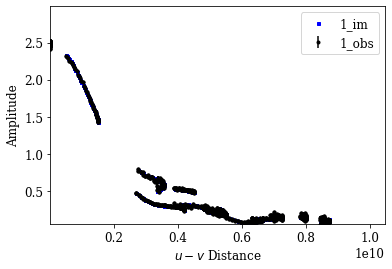

<AxesSubplot:xlabel='$u-v$ Distance', ylabel='Amplitude'>

In [29]:
# Image total flux with bispectrum
flux = zbl
out  = eh.imager_func(obs, gaussprior, gaussprior, flux,
                      d1='vis', s1='simple', show_updates = False,
                      alpha_s1=1, alpha_d1=100,
                      alpha_flux=100, alpha_cm=50,
                      maxit=100, ttype='nfft')

# Blur the image with a circular beam and image again to help convergance
out = out.blur_circ(res)
out = eh.imager_func(obs, out, out, flux,
                     d1='vis', s1='tv', show_updates = False,
                     alpha_s1=1, alpha_d1=50,
                     alpha_flux=100, alpha_cm=50,
                     maxit=100,ttype='nfft')

out = out.blur_circ(res/2.0)
out = eh.imager_func(obs, out, out, flux,
                     d1='vis', s1='tv', show_updates = False,
                     alpha_s1=1, alpha_d1=10,
                     alpha_flux=100, alpha_cm=50,
                     maxit=100,ttype='nfft')


# Self - calibrate and image with vis amplitudes
obs_sc = sc.self_cal(obs, out)

out_sc = out.blur_circ(res)
out_sc = eh.imager_func(obs_sc, out_sc, out_sc, flux,
                        d1='vis', s1='simple', show_updates = False,
                        alpha_s1=1, alpha_d1=100,
                        alpha_flux=100, alpha_cm=50,
                        maxit=50,ttype='nfft')


# Compare the visibility amplitudes to the data
out = out_sc
eh.comp_plots.plotall_obs_im_compare(obs, out,'uvdist','amp', clist=['b','m'],conj=True)

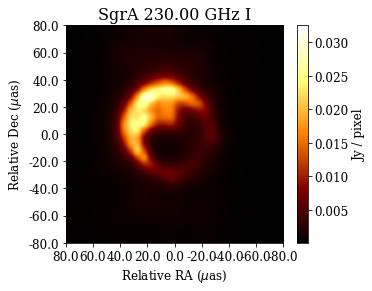

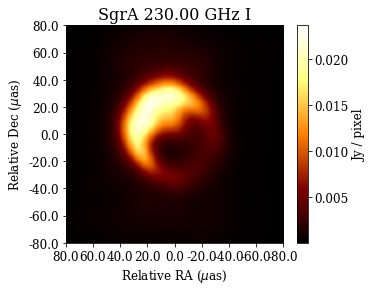

In [30]:
# Blur the final image with 1/2 the clean beam
outblur = out.blur_gauss(beamparams, 0.5)
out.display()
outblur.display()
plt.show()

In [31]:
print("metrics for rotated algorithm is ", compare(im,out))

metrics for rotated algorithm is  [0.8851907407520897, 0.461159709736269, 2.0706466608048364e-13]


# Multi-Frequency

In [32]:
# Load the image and the array
im = eh.image.load_txt('./models/avery_sgra_eofn.txt')
eht = eh.array.load_txt('./arrays/EHT2017.txt')

# Add a spectral index to the image
alpha = 2.5
im.rf = 230.e9
im = im.add_const_mf(alpha)

im230 = im.get_image_mf(230.e9)
im345 = im.get_image_mf(345.e9)

# Observe the image at two different frequencies
tint_sec = 120
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 2e9
obs230 = im230.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                       sgrscat=False, ampcal=True, phasecal=True)
obs345 = im345.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                       sgrscat=False, ampcal=True, phasecal=True)
obslist = [obs230,obs345]

#observe at 345 with no spectral index applied
im345_nospec = im230.copy()
im345_nospec.rf = 345e9
obs345_nospec = im345_nospec.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                                     sgrscat=False, ampcal=True, phasecal=True)
obslist_nospec = [obs230,obs345_nospec]

# Resolution
beamparams230 = obs230.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res230 = obs230.res() # nominal array resolution, 1/longest baseline
beamparams345 = obs345.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res345 = obs345.res() # nominal array resolution, 1/longest baseline
print("Nominal Resolution: " ,res230,res345)

# Generate an image prior
npix = 64
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs230, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))


## Image both frequencies independently with complex visibilities
flux230 = zbl
imgr230  = eh.imager.Imager(obs230, gaussprior, gaussprior, flux230,
                            data_term={'vis':100}, show_updates=False,
                            reg_term={'tv2':1.e4,'l1':5},
                            maxit=200, ttype='nfft')
imgr230.make_image_I(show_updates=False)
out230 = imgr230.out_last()


flux345 = im345.total_flux()
imgr345  = eh.imager.Imager(obs345, gaussprior, gaussprior, flux345,
                            data_term={'vis':100}, show_updates=False,
                            reg_term={'tv2':1},
                            maxit=200, ttype='nfft')
imgr345.make_image_I(show_updates=False)
out345 = imgr345.out_last()

## Image both frequencies together without multifrequency imaging (no spectral index)
imgr  = eh.imager.Imager(obslist_nospec, gaussprior, gaussprior, zbl,
                         data_term={'vis':100}, show_updates=False,
                         reg_term={'tv2':1.e4,'l1':5},
                         maxit=200, ttype='nfft')
imgr.make_image_I(show_updates=False)
out_nospec = imgr.out_last()

# Image both frequencies together with spectral index
plt.close('all')
gaussprior = gaussprior.add_const_mf(3)
imgr  = eh.imager.Imager(obslist, gaussprior, gaussprior, zbl,
                         data_term={'vis':100}, show_updates=False,
                         reg_term={'tv2':1.e4,'l1':5},
                         maxit=100, ttype='nfft')
imgr.make_image_I(mf=True, show_updates=False)
out = imgr.out_last()

for i in range(3): # blur and reimage
    out = out.blur_circ(15*eh.RADPERUAS)
    imgr.maxit_next=500
    imgr.init_next = out
    imgr.make_image_I(mf=True,show_updates=False)
    out = imgr.out_last()

Loading text image:  ./models/avery_sgra_eofn.txt
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Nominal Resolution:  1.1454586301106233e-10 7.636390867404155e-11
Initializing imager data products . . .
Imager run 1 
time: 0.560175 s
J: 274.402611
chi2_vis : 3.50 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Initializing imager data products . . .
Imager run 1 
time: 0.610408 s
J: 1054.490294
chi2_vis : 11

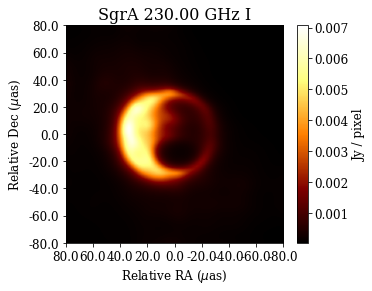

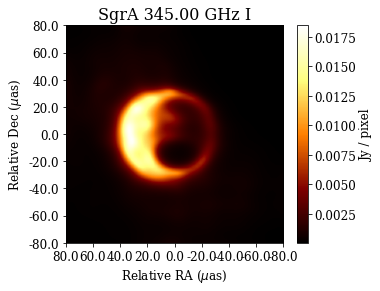

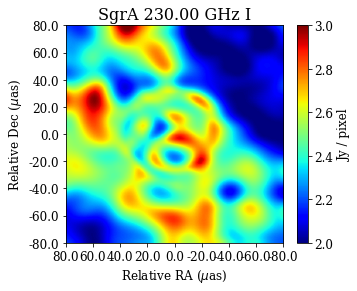

2.4884327618 2.488423810547757
6.857314341339055 6.856793069708596
1.3005766136572137 1.499183456421282


In [33]:
# look at results
out230_mf = out.get_image_mf(230.e9)
out345_mf = out.get_image_mf(345.e9)
out_specind = out.copy()
out_specind.imvec = out.specvec

out230_mf.display()
out345_mf.display()
out_specind.display(cfun='jet',cbar_lims=[2,3])

print(im230.total_flux(), out230_mf.total_flux())
print(im345.total_flux(), out345_mf.total_flux())
print(obs345.chisq(out345_mf), obs230.chisq(out230_mf))

In [34]:
print("metrics for 230Ghz is ", compare(im230,out230_mf))
print("metrics for 345Ghz is ", compare(im345,out345_mf))

metrics for 230Ghz is  [0.9942076383734406, 0.11146471458343728, 5.0048613132693715e-14]
metrics for 345Ghz is  [0.9942648707661771, 0.1125372871425998, 1.3924487785545942e-13]
